说明：

这一版重点改善其中的绘图部分，要求有训练之前的加过展示

呈现结果
- 没有 rl 训练部分 sdm
- manul 部分操作的
- 有了 rl 框架之后的 随机 rl 部分（sb3）
- 有了 rl 框架之后的 gym sb 操作 rl 部分（sb3）
- 有了 rl 框架之后的 预测的操作 rl 部分（sb3） 

优化部分：

- 初始状态部分（参数、格式、e.g. 如何操作的）
- 终止边界状态部分
- 奖励部分 数值检查
- 边界奖励部分
- action 部分
- 如何对应改编参数部分是否正常
- next 部分检查

调试过程：
在关键之处打断点
比如 
- step

### v4 代码

#### 测试环境

- real 数据添加部分

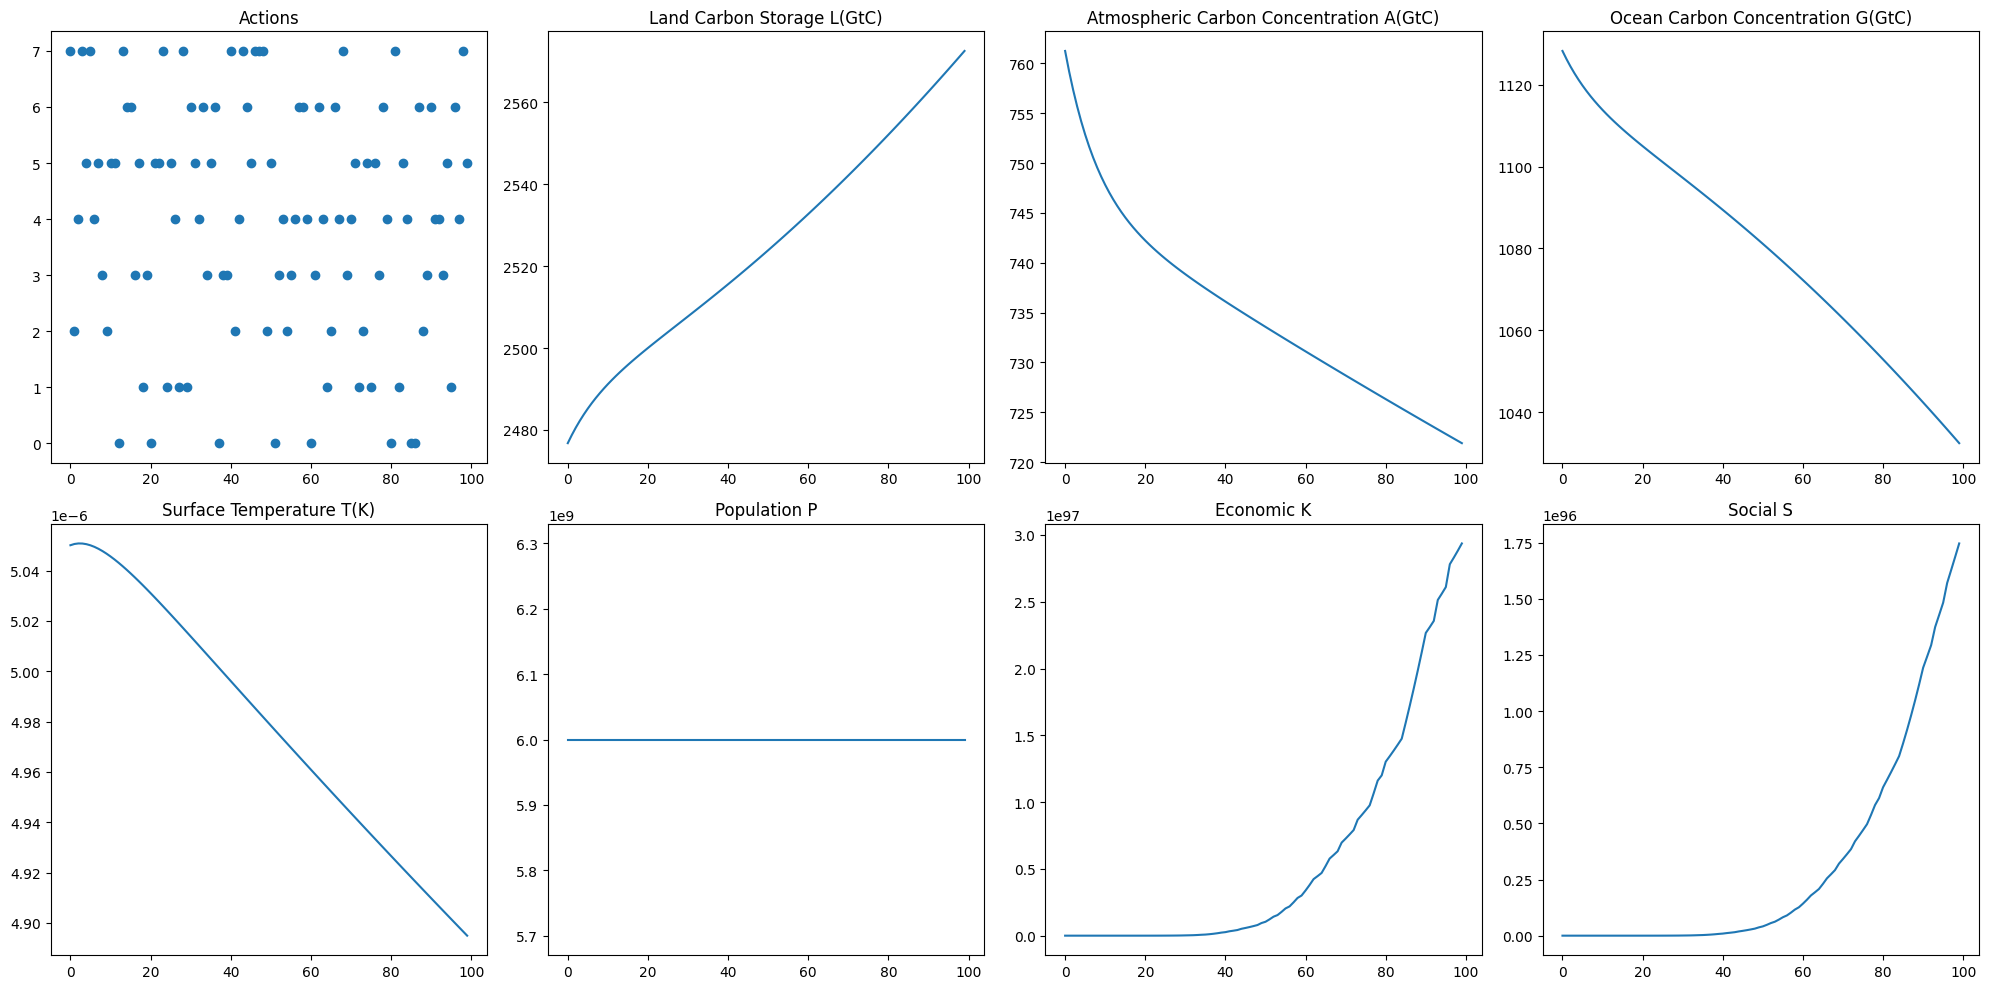

In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import gymnasium as gym

# import gymnasium as gym
from gymnasium import spaces


import matplotlib.animation as animation

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy



class cG_LAGTPKS_Environment(gym.Env):
    # 拓展部分
    # 这样就是 self 的属性了
    Sigma = 1.5 * 1e8
    Cstar = 5500
    a0 = 0.03
    aT = 3.2 * 1e3
    l0 = 26.4
    lT = 1.1 * 1e6
    delta = 0.01
    m = 1.5
    g = 0.02
    p = 0.04
    Wp = 2000
    q0 = 20
    b = 5.4 * 1e-7
    yE = 147
    eB = 4 * 1e10
    eF = 4 * 1e10
    i = 0.25
    k0 = 0.1
    aY = 0.
    aB = 3e5
    aF = 5e6
    aR = 7e-18
    sS = 1. / 50.
    sR = 1.
    ren_sub = .5
    carbon_tax = .5
    i_DG = 0.1
    L0 = 0

    # 自定义的参数部分
    expP = 2. / 5
    expK = 2. / 5.

    Wl = 2000
    

    def __init__(self, reward_type = None):
       
        
        # self.state = [0, 0, 0, 0, 0]
        # self.iniDynVar['L'] = 0.5
        # self.iniDynVar['A'] = 0.3
        # self.iniDynVar['G'] = 0.2
        # self.iniDynVar['T'] = 0.1
        # self.iniDynVar['P'] = 0.4
        # self.iniDynVar['K'] = 0.6
        # self.iniDynVar['S'] = 0.7

        # TODO
        # 本质由于改变的是位置的部分，动作部分变化有限，所以是个离散的动作空间
        # 本身属性数值定义有问题
        self.action_space = spaces.MultiDiscrete([2, 2, 2])
        
        # 虽然是单个时间步长求解，但是变化范围对应值很多，所以是连续的
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float64)

        # self.state = np.zeros(7) # 这是默认写法，
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        
        self.steps = 0
        self.max_steps = 100  # 限制最大步数
        
        
        # Initialise class variables
        self.dt = 1
        
        # state 部分
        # 默认管理措施
        # Here default parameters before management is used
        self.aR_default=7e-18
        self.aB_default=3e5
        self.aF_default=5e6
        self.i_default=0.25
        
        
        # 默认的自然保护是关闭的 
        self.Lprot=False
        self.P_PB=1e6
        self.A_PB = 0
        
        self.t = 0

        # self.params={}
        # self.params['Sigma'] = self.Sigma
        # self.params['i'] = self.i
        # self.params['wL'] = self.Wp
        # self.params['yE'] = self.yE

        # self.params['eB'] = self.eB
        # self.params['eF'] = self.eF
        # self.params['aR'] = self.aR

        # self.params['g'] = self.g
        # self.params['k0'] = self.k0

        # self.params['sR'] = self.sR
        # self.params['sS'] = self.sS

        # self.params['l0'] = self.l0
        
        # 奖励部分
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)
        
        
        
        # 方便绘制
        self.real_states = []

    # 基本环境部分定义
    
    def B(self, L, P, K, G, S):
        # 完整的过程计算部分
        Xb = self.aB * L ** 2  # L
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_B = Xb * Z / self.eB

        return final_B

    def F(self, G, P, K, L, S):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2  # G
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_F = Xf * Z / self.eF

        return final_F

    def R(self, S, P, K, L, G):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2  # S
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_R = Xr * Z / self.aR

        return final_R

    def Y(self, B, F, R):
        return self.yE * (self.eB * B + self.eF * F + R)

    def W(self, Y, P, L):
        return (1. - self.i) * Y / P + self.Wl * L / self.Sigma

    # TODO 加入参数部分，仿照 ays 中操作
    def copan_dDynVar(self, LAGTPKS, t=0):
        # 1 基本量拿取
        L, A, G, T, P, K, S = self.state


        # 2 中间量计算
        # 包含了
        # 需要还有过程的方程部分

        def phot(L, A, T):
            return (self.l0 - self.lT * T) * np.sqrt(A) / np.sqrt(self.Sigma)

        def resp(L, T):
            return self.a0 + self.aT * T

        def diff(L, A, G):
            return self.delta * (self.Cstar - L - G - (1 + self.m) * A)

        def fert(P, W):
            return 2 * self.p * self.Wp * W / (self.Wp ** 2 + W ** 2)

        def mort(P, W):
            # return self.q0 / (W) + self.qP * P /self.Sigma
            return self.q0 / (W)

            # 补充:

        # 就是 B 中的前面部分
        # Xb = self.aB * L ** 2
        # Xf = self.aF * G ** 2
        # Xr = self.aR * S ** 2

        ###################### 辅助量############################
        # 公共部分的变量计算 Z 放在函数内
        # biomass B, fossil F, and renewable energy flow R
        # TODO 这里的相关定义量应该参照于 climate 中集体拿相关量进行定义操作
        B = self.B(L, P, K, G, S)
        F = self.F(G, P, K, L, S)
        R = self.R(S, P, K, L, G)

        # Economic output i
        Y = self.Y(B, F, R)
        # wellbeing is determined by per capita
        W = self.W(Y, P, L)  # 不断与上面的量有关

        ################动态量#############################
        # 3 动态量计算
        # photosynthesis(first term) and respiration (second term),
        dL = (phot(L, A, T) - resp(L, T)) * L - B
        # ocean-atmosphere discusion,导致相关的变化过程
        dA = -dL + diff(L, A, G)
        # Geological carbon stock G declines beacuse of fossil fuel burning
        dG = -dL
        # global mean temperature
        # dT = self.params['g'] * (A/self.params['Sigma'] -  T)
        dT = self.g * (A / self.Sigma - T)
        # Population P has a fertility (first term) and mortality (second term)
        # 出生率与死亡率与基本人口和人民福祉很大关系
        dP = P * (fert(P, W) - mort(P, W))
        # Physical capital K grows since part of GWP Y is
        # Y Gross World Product | K capital stock
        # dK = self.params['i'] * Y - self.params['k'] * K
        dK = self.i * Y - self.k0 * K
        # r renewable knowledge stock S, same as ays
        # dS = self.params['sR'] * R - self.params['sS'] * S
        dS = self.sR * R - self.sS * S

        return dL, dA, dG, dT, dP, dK, dS


    # 辅助函数部分

    # 开始绘制图形
    def plot_all_dynamics(self, num):
           # 虽然这里只有一，但是本质还是二维数组
        # LAGTPKS = np.random.rand(1, 7)

        time = np.linspace(0, 100, 1000)

        # for i in range(num):
        #     x0 = LAGTPKS[i]
        #     traj = odeint(self.dDynVar, x0, time)

        #     # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        #     for j in range(7):
        #         ax.plot(time, traj[:, j])

        # x0 = LAGTPKS[0]
        
        env.reset()
        traj = odeint(self.copan_dDynVar, self.state, time)

        # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # create 7 subplots, one for each dimension

        # title_tuple = ['dL','dA','dG','dT','dP','dK','dS']
        # for j in range(7):
        #     axs[j].plot(time, traj[:, j])

        #     # axs[j].set_title(f'Dimension {j+1}')
        #     axs[j].set_title(title_tuple[j])
        #     # axs[j].legend()  # 添加图例

        # plt.tight_layout()  # adjust the layout so that the plots do not overlap
        # plt.show()

        #     # 绘制状态值和动作
        # fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # 绘制 actions
        # 在 [0,0] 散点图中绘制 actions，要求使用散点图
        # axs[0, 0].scatter(range(len(total_action)), total_action)
        axs[0, 0].set_title('Actions')

        # # 绘制状态值

        states = np.array(traj)

        # 绘制各个状态变量随时间步变化的曲线
        axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
        axs[0, 1].set_title('Land Carbon Storage L(GtC)')

        axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
        axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

        axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
        axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

        axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
        axs[1, 0].set_title('Surface Temperature T(K)')

        axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
        axs[1, 1].set_title('Population P')

        axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
        axs[1, 2].set_title('Economic K')

        axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
        axs[1, 3].set_title('Social S')

        plt.tight_layout()
        plt.show()


   
        
    # def __get_observation(self):
    def get_observation(self, next_t):
        # 获取观察的部分
        # 从外部获取，然后转换为对应状态，
        # 如果联机就可以外部访问获取了(无非是 ode 这里获取)
        
        # 对应就是 theo 里面的 odesolver
        """This is where we solve the dynamical system of equations to get the next state"""
        ode_solutions = odeint(func=self.copan_dDynVar,
                            y0=self.state,
                            t=[self.t, next_t],
                            mxstep=10000)
        # ode_result = odeint(self.copan_dDynVar, self.state, [0, 1])
        return ode_solutions[-1] # 返回的应该是最后一列的数据
    
    
    def done_state_arrived_at_final_state(self):
        if self.t>400: # （运行时间过久的话，经过适当的改编了）
            return True
        else:
            return False
    
    def done_state_inside_planetary_boundaries(self):
        """Check to see if we are in a terminal state"""
        # # 还需要再执行一个时间步长才能判断是否到达边界
        # self.apply_action(action)
        # TODO, 可以增加复杂的条件
        L,A,G,T,P,K,S = self.state
        
        is_inside = True
        
        if A > self.A_PB  or P < self.P_PB:
            is_inside = False
            #print("Outside PB!")
        return is_inside
    
    def normalize_state(self, cur_state):
        initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
        
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        initial_state = np.array(list(initials.values())) 
        
        normalized = np.array(cur_state)/(initial_state+np.array(cur_state))
        return normalized
    
    # reward_function
    def get_reward_function(self, reward_type):
        """Choosing a reward function"""
        # 可以替换多种奖励类型
        
        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            # _, _, _, _, W = self.compute_derived_variables()
            # state_vec = np.array([A, W/18588, P])
            # r_t = np.linalg.norm(state_vec - self.PB_vec)
            if  self.done_state_inside_planetary_boundaries():
                return round(np.sqrt(self.A_PB - A), 1)
            else:
                return 0

        return planet_boundaries
    
    
     # def __apply_action(self, action): # 该写法是私有方法里面的部分
    def apply_action(self, action):
        # 该函数来源于改变其中的参数部分
        # 对应的是 参数对 LAGTPKS 状态的影响（  def adjust_parameters(self, a_t=0):）
        # 参照 theo 中的写法
        # 参照 ays 中的写法
        # theo:
        # """Adjust the parameters before computing the ODE by using the actions"""
        # asy:
        # ays 的结果更加合理改编
        # ays 中是返回一个结果对应列表，反正就是要实行动作对其产生影响的效果
        #  parameter_list = [(self.beta_LG if action_tuple[0] else self.beta, self.eps, self.phi, self.rho, 
                        #    self.sigma_ET if action_tuple[1] else self.sigma, self.tau_A, self.tau_S, self.theta)]
        
        # 被调用的关键：self._adjust_parameters(action)
        
        # 本身的数据结构
        # self.action_space = spaces.MultiDiscrete([2, 2, 2])
        # ays 与 copan 区别在于是否直接返回的是参数列表，还是应用了
        
        # 判断第一维
        # 对应措施：subsidy
        if action[0] == 0:
            self.aR = self.aR_default * (1 + self.ren_sub)
        else:
            self.aR = self.aR_default
            
        # 第二维
        # 对应措施：carbon tax
        if action[1] == 0:
            self.aB = self.aB_default * (1 - self.carbon_tax)
            self.aF = self.aF_default*(1 - self.carbon_tax)
        else:
            self.aB = self.aB_default
            self.aF = self.aF_default
            
        # 第三维
        # 对应措施：nature protection
        if action[2] == 0:
            self.Lprot=True
        else:
            self.Lprot=False
            
        # 已经隐式改变了就行
    


    # 标准化组件一般都定义在后面操作
    
    def reset(self, seed=None, options=None):
        """
        在每次新回合开始时重置环境状态。
        返回初始状态。
        Resetting the environment at the start of an episode
        """
        
        # self.state = np.array([50, 50])  # 初始化为中间值
        # self.steps = 0
        initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
        
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        self.state = np.array(list(initials.values())) 
        self.done = False
        self.t = 0
        
        return self.state, {}
    
    def step(self, action):
        """
        在环境中执行一个动作，并返回新的状态、奖励、是否结束和其他信息。
        参数:
        - action: 代理采取的动作
        
        返回:
        - state: 新的状态
        - reward: 根据新状态计算的奖励
        - done: 布尔值，指示回合是否结束
        - info: 额外信息，通常用于调试
        """
        
        # 增加一个时间步长来进行ode求解
        next_t = self.t + self.dt
        
        # 更新状态，根据动作和当前状态进行计算
        # self.state = self.state + action  # 简单线性模型
        # 复杂的利用 apply_action 来进行
        self.apply_action(action)
        
        # 补充执行的obs state
        # state = self.__get_observation()
        self.state = self.get_observation(next_t)
        
        # 执行补充过程结束即可
        self.t = next_t
        
        if self.done_state_arrived_at_final_state():
            done = True
            
            
        # 计算奖励
        reward=self.reward_function()
        
        # 补充计算 done 系列
        # done 受影响因素：时间步数，是否到达边界
        # 常规的：if self.steps >= self.max_steps:
        if self.done_state_inside_planetary_boundaries():
            self.done = True
        else:
            self.done = False
        
        # 空字典代替
        truncated = False
        info = {}
        
        self.real_states.append(self.state)
        
        # optial: 是否缩放
        trafo_state=self.normalize_state(self.state)
        
        # 考虑到 sb3 环境替换的关键，简化为三者，使用空白代替
        return trafo_state, reward, self.done, truncated, info
    
    # def seed(self):
    #     pass
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass
        

    
    



   
        
if  __name__ == '__main__':

    # 动作翻译部分
    def action2number(action_numpy):
        action = action_numpy.tolist()
        
        if action == [1, 1, 1]:
            return 0, 'default'
        elif action == [0, 1, 1]:
            return 1, 'subsidy'
        elif action == [1, 0, 1]:
            return 2, 'carbon_tax'
        elif action == [1, 1, 0]:
            return 3, 'nature_protection'
        elif action == [0, 0, 1]:
            return 4, 'subsidy + carbon_tax'
        elif action == [0, 1, 0]:
            return 5, 'subsidy + nature_protection'
        elif action == [1, 0, 0]:
            return 6, 'carbon_tax + nature_protection'
        elif action == [0, 0, 0]:
            return 7, 'subsidy + carbon_tax + nature_protection'




    env = cG_LAGTPKS_Environment()
    obs = env.reset()
    
    total_action = []
    total_state = []
    
    for i in range(100):
        action = env.action_space.sample()
        obs, reward, done, _, info = env.step(action)
        
        # print(obs, reward, action)
        action_number = action2number(action)
        
        # print(action_number[0], action_number[1])
        total_action.append(action_number[0])
        total_state.append(obs)
        # 记录总绘制部分
        if done:
            print (i)
            break
        
        
        
        # 绘制状态值和动作
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # 绘制 actions
    # 在 [0,0] 散点图中绘制 actions，要求使用散点图
    axs[0, 0].scatter(range(len(total_action)), total_action)
    axs[0, 0].set_title('Actions')

    # 绘制状态值

    states = env.real_states
    states = np.array(states)

    # 绘制各个状态变量随时间步变化的曲线
    axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
    axs[0, 1].set_title('Land Carbon Storage L(GtC)')

    axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
    axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

    axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
    axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

    axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
    axs[1, 0].set_title('Surface Temperature T(K)')

    axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
    axs[1, 1].set_title('Population P')

    axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
    axs[1, 2].set_title('Economic K')

    axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
    axs[1, 3].set_title('Social S')

    plt.tight_layout()
    plt.show()



### 模型训练的部分

In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import gymnasium as gym

# import gymnasium as gym
from gymnasium import spaces


import matplotlib.animation as animation

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy



class cG_LAGTPKS_Environment(gym.Env):
    # 拓展部分
    # 这样就是 self 的属性了
    Sigma = 1.5 * 1e8
    Cstar = 5500
    a0 = 0.03
    aT = 3.2 * 1e3
    l0 = 26.4
    lT = 1.1 * 1e6
    delta = 0.01
    m = 1.5
    g = 0.02
    p = 0.04
    Wp = 2000
    q0 = 20
    b = 5.4 * 1e-7
    yE = 147
    eB = 4 * 1e10
    eF = 4 * 1e10
    i = 0.25
    k0 = 0.1
    aY = 0.
    aB = 3e5
    aF = 5e6
    aR = 7e-18
    sS = 1. / 50.
    sR = 1.
    ren_sub = .5
    carbon_tax = .5
    i_DG = 0.1
    L0 = 0

    # 自定义的参数部分
    expP = 2. / 5
    expK = 2. / 5.

    Wl = 2000
    

    def __init__(self, reward_type = None):
       
        
        # self.state = [0, 0, 0, 0, 0]
        # self.iniDynVar['L'] = 0.5
        # self.iniDynVar['A'] = 0.3
        # self.iniDynVar['G'] = 0.2
        # self.iniDynVar['T'] = 0.1
        # self.iniDynVar['P'] = 0.4
        # self.iniDynVar['K'] = 0.6
        # self.iniDynVar['S'] = 0.7

        # TODO
        # 本质由于改变的是位置的部分，动作部分变化有限，所以是个离散的动作空间
        # 本身属性数值定义有问题
        self.action_space = spaces.MultiDiscrete([2, 2, 2])
        
        # 虽然是单个时间步长求解，但是变化范围对应值很多，所以是连续的
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float64)

        # self.state = np.zeros(7) # 这是默认写法，
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        
        self.steps = 0
        self.max_steps = 100  # 限制最大步数
        
        
        # Initialise class variables
        self.dt = 1
        
        # state 部分
        # 默认管理措施
        # Here default parameters before management is used
        self.aR_default=7e-18
        self.aB_default=3e5
        self.aF_default=5e6
        self.i_default=0.25
        
        
        # 默认的自然保护是关闭的 
        self.Lprot=False
        self.P_PB=1e6
        self.A_PB = 0
        
        self.t = 0

        # self.params={}
        # self.params['Sigma'] = self.Sigma
        # self.params['i'] = self.i
        # self.params['wL'] = self.Wp
        # self.params['yE'] = self.yE

        # self.params['eB'] = self.eB
        # self.params['eF'] = self.eF
        # self.params['aR'] = self.aR

        # self.params['g'] = self.g
        # self.params['k0'] = self.k0

        # self.params['sR'] = self.sR
        # self.params['sS'] = self.sS

        # self.params['l0'] = self.l0
        
        # 奖励部分
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)
        
        
        
        # 方便绘制
        self.real_states = []

    # 基本环境部分定义
    
    def B(self, L, P, K, G, S):
        # 完整的过程计算部分
        Xb = self.aB * L ** 2  # L
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_B = Xb * Z / self.eB

        return final_B

    def F(self, G, P, K, L, S):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2  # G
        Xr = self.aR * S ** 2
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_F = Xf * Z / self.eF

        return final_F

    def R(self, S, P, K, L, G):
        Xb = self.aB * L ** 2
        Xf = self.aF * G ** 2
        Xr = self.aR * S ** 2  # S
        X = Xb + Xf + Xr

        Z = P ** self.expP * K ** self.expK / X ** (4. / 5.)
        final_R = Xr * Z / self.aR

        return final_R

    def Y(self, B, F, R):
        return self.yE * (self.eB * B + self.eF * F + R)

    def W(self, Y, P, L):
        return (1. - self.i) * Y / P + self.Wl * L / self.Sigma

    # TODO 加入参数部分，仿照 ays 中操作
    def copan_dDynVar(self, LAGTPKS, t=0):
        # 1 基本量拿取
        L, A, G, T, P, K, S = self.state


        # 2 中间量计算
        # 包含了
        # 需要还有过程的方程部分

        def phot(L, A, T):
            return (self.l0 - self.lT * T) * np.sqrt(A) / np.sqrt(self.Sigma)

        def resp(L, T):
            return self.a0 + self.aT * T

        def diff(L, A, G):
            return self.delta * (self.Cstar - L - G - (1 + self.m) * A)

        def fert(P, W):
            return 2 * self.p * self.Wp * W / (self.Wp ** 2 + W ** 2)

        def mort(P, W):
            # return self.q0 / (W) + self.qP * P /self.Sigma
            return self.q0 / (W)

            # 补充:

        # 就是 B 中的前面部分
        # Xb = self.aB * L ** 2
        # Xf = self.aF * G ** 2
        # Xr = self.aR * S ** 2

        ###################### 辅助量############################
        # 公共部分的变量计算 Z 放在函数内
        # biomass B, fossil F, and renewable energy flow R
        # TODO 这里的相关定义量应该参照于 climate 中集体拿相关量进行定义操作
        B = self.B(L, P, K, G, S)
        F = self.F(G, P, K, L, S)
        R = self.R(S, P, K, L, G)

        # Economic output i
        Y = self.Y(B, F, R)
        # wellbeing is determined by per capita
        W = self.W(Y, P, L)  # 不断与上面的量有关

        ################动态量#############################
        # 3 动态量计算
        # photosynthesis(first term) and respiration (second term),
        dL = (phot(L, A, T) - resp(L, T)) * L - B
        # ocean-atmosphere discusion,导致相关的变化过程
        dA = -dL + diff(L, A, G)
        # Geological carbon stock G declines beacuse of fossil fuel burning
        dG = -dL
        # global mean temperature
        # dT = self.params['g'] * (A/self.params['Sigma'] -  T)
        dT = self.g * (A / self.Sigma - T)
        # Population P has a fertility (first term) and mortality (second term)
        # 出生率与死亡率与基本人口和人民福祉很大关系
        dP = P * (fert(P, W) - mort(P, W))
        # Physical capital K grows since part of GWP Y is
        # Y Gross World Product | K capital stock
        # dK = self.params['i'] * Y - self.params['k'] * K
        dK = self.i * Y - self.k0 * K
        # r renewable knowledge stock S, same as ays
        # dS = self.params['sR'] * R - self.params['sS'] * S
        dS = self.sR * R - self.sS * S

        return dL, dA, dG, dT, dP, dK, dS


    # 辅助函数部分

    # 开始绘制图形
    def plot_all_dynamics(self, num):
           # 虽然这里只有一，但是本质还是二维数组
        # LAGTPKS = np.random.rand(1, 7)

        time = np.linspace(0, 100, 1000)

        # for i in range(num):
        #     x0 = LAGTPKS[i]
        #     traj = odeint(self.dDynVar, x0, time)

        #     # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        #     for j in range(7):
        #         ax.plot(time, traj[:, j])

        # x0 = LAGTPKS[0]
        
        env.reset()
        traj = odeint(self.copan_dDynVar, self.state, time)

        # 遍历绘制 LAGTPKS 的每个变量数值随时间变化的曲线
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # create 7 subplots, one for each dimension

        # title_tuple = ['dL','dA','dG','dT','dP','dK','dS']
        # for j in range(7):
        #     axs[j].plot(time, traj[:, j])

        #     # axs[j].set_title(f'Dimension {j+1}')
        #     axs[j].set_title(title_tuple[j])
        #     # axs[j].legend()  # 添加图例

        # plt.tight_layout()  # adjust the layout so that the plots do not overlap
        # plt.show()

        #     # 绘制状态值和动作
        # fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # 绘制 actions
        # 在 [0,0] 散点图中绘制 actions，要求使用散点图
        # axs[0, 0].scatter(range(len(total_action)), total_action)
        axs[0, 0].set_title('Actions')

        # # 绘制状态值

        states = np.array(traj)

        # 绘制各个状态变量随时间步变化的曲线
        axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
        axs[0, 1].set_title('Land Carbon Storage L(GtC)')

        axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
        axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

        axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
        axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

        axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
        axs[1, 0].set_title('Surface Temperature T(K)')

        axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
        axs[1, 1].set_title('Population P')

        axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
        axs[1, 2].set_title('Economic K')

        axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
        axs[1, 3].set_title('Social S')

        plt.tight_layout()
        plt.show()


   
        
    # def __get_observation(self):
    def get_observation(self, next_t):
        # 获取观察的部分
        # 从外部获取，然后转换为对应状态，
        # 如果联机就可以外部访问获取了(无非是 ode 这里获取)
        
        # 对应就是 theo 里面的 odesolver
        """This is where we solve the dynamical system of equations to get the next state"""
        ode_solutions = odeint(func=self.copan_dDynVar,
                            y0=self.state,
                            t=[self.t, next_t],
                            mxstep=10000)
        # ode_result = odeint(self.copan_dDynVar, self.state, [0, 1])
        return ode_solutions[-1] # 返回的应该是最后一列的数据
    
    
    def done_state_arrived_at_final_state(self):
        if self.t>400: # （运行时间过久的话，经过适当的改编了）
            return True
        else:
            return False
    
    def done_state_inside_planetary_boundaries(self):
        """Check to see if we are in a terminal state"""
        # # 还需要再执行一个时间步长才能判断是否到达边界
        # self.apply_action(action)
        # TODO, 可以增加复杂的条件
        L,A,G,T,P,K,S = self.state
        
        is_inside = True
        
        if A > self.A_PB  or P < self.P_PB:
            is_inside = False
            #print("Outside PB!")
        return is_inside
    
    def normalize_state(self, cur_state):
        initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
        
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        initial_state = np.array(list(initials.values())) 
        
        normalized = np.array(cur_state)/(initial_state+np.array(cur_state))
        return normalized
    
    # reward_function
    def get_reward_function(self, reward_type):
        """Choosing a reward function"""
        # 可以替换多种奖励类型
        
        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            # _, _, _, _, W = self.compute_derived_variables()
            # state_vec = np.array([A, W/18588, P])
            # r_t = np.linalg.norm(state_vec - self.PB_vec)
            if  self.done_state_inside_planetary_boundaries():
                return round(np.sqrt(self.A_PB - A), 1)
            else:
                return 0

        return planet_boundaries
    
    
     # def __apply_action(self, action): # 该写法是私有方法里面的部分
    def apply_action(self, action):
        # 该函数来源于改变其中的参数部分
        # 对应的是 参数对 LAGTPKS 状态的影响（  def adjust_parameters(self, a_t=0):）
        # 参照 theo 中的写法
        # 参照 ays 中的写法
        # theo:
        # """Adjust the parameters before computing the ODE by using the actions"""
        # asy:
        # ays 的结果更加合理改编
        # ays 中是返回一个结果对应列表，反正就是要实行动作对其产生影响的效果
        #  parameter_list = [(self.beta_LG if action_tuple[0] else self.beta, self.eps, self.phi, self.rho, 
                        #    self.sigma_ET if action_tuple[1] else self.sigma, self.tau_A, self.tau_S, self.theta)]
        
        # 被调用的关键：self._adjust_parameters(action)
        
        # 本身的数据结构
        # self.action_space = spaces.MultiDiscrete([2, 2, 2])
        # ays 与 copan 区别在于是否直接返回的是参数列表，还是应用了
        
        # 判断第一维
        # 对应措施：subsidy
        if action[0] == 0:
            self.aR = self.aR_default * (1 + self.ren_sub)
        else:
            self.aR = self.aR_default
            
        # 第二维
        # 对应措施：carbon tax
        if action[1] == 0:
            self.aB = self.aB_default * (1 - self.carbon_tax)
            self.aF = self.aF_default*(1 - self.carbon_tax)
        else:
            self.aB = self.aB_default
            self.aF = self.aF_default
            
        # 第三维
        # 对应措施：nature protection
        if action[2] == 0:
            self.Lprot=True
        else:
            self.Lprot=False
            
        # 已经隐式改变了就行
    


    # 标准化组件一般都定义在后面操作
    
    def reset(self, seed=None, options=None):
        """
        在每次新回合开始时重置环境状态。
        返回初始状态。
        Resetting the environment at the start of an episode
        """
        
        # self.state = np.array([50, 50])  # 初始化为中间值
        # self.steps = 0
        initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
        
        # self.state = [0, 0, 0, 0, 0, 0, 0]
        self.state = np.array(list(initials.values())) 
        self.done = False
        self.t = 0
        
        return self.state, {}
    
    def step(self, action):
        """
        在环境中执行一个动作，并返回新的状态、奖励、是否结束和其他信息。
        参数:
        - action: 代理采取的动作
        
        返回:
        - state: 新的状态
        - reward: 根据新状态计算的奖励
        - done: 布尔值，指示回合是否结束
        - info: 额外信息，通常用于调试
        """
        
        # 增加一个时间步长来进行ode求解
        next_t = self.t + self.dt
        
        # 更新状态，根据动作和当前状态进行计算
        # self.state = self.state + action  # 简单线性模型
        # 复杂的利用 apply_action 来进行
        self.apply_action(action)
        
        # 补充执行的obs state
        # state = self.__get_observation()
        self.state = self.get_observation(next_t)
        
        # 执行补充过程结束即可
        self.t = next_t
        
        if self.done_state_arrived_at_final_state():
            done = True
            
            
        # 计算奖励
        reward=self.reward_function()
        
        # 补充计算 done 系列
        # done 受影响因素：时间步数，是否到达边界
        # 常规的：if self.steps >= self.max_steps:
        if self.done_state_inside_planetary_boundaries():
            self.done = True
        else:
            self.done = False
        
        # 空字典代替
        truncated = False
        info = {}
        
        self.real_states.append(self.state)
        
        # optial: 是否缩放
        trafo_state=self.normalize_state(self.state)
        
        # 考虑到 sb3 环境替换的关键，简化为三者，使用空白代替
        return trafo_state, reward, self.done, truncated, info
    
    # def seed(self):
    #     pass
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass
        

    
    



   
        
if  __name__ == '__main__':

    # 动作翻译部分
    def action2number(action_numpy):
        action = action_numpy.tolist()
        
        if action == [1, 1, 1]:
            return 0, 'default'
        elif action == [0, 1, 1]:
            return 1, 'subsidy'
        elif action == [1, 0, 1]:
            return 2, 'carbon_tax'
        elif action == [1, 1, 0]:
            return 3, 'nature_protection'
        elif action == [0, 0, 1]:
            return 4, 'subsidy + carbon_tax'
        elif action == [0, 1, 0]:
            return 5, 'subsidy + nature_protection'
        elif action == [1, 0, 0]:
            return 6, 'carbon_tax + nature_protection'
        elif action == [0, 0, 0]:
            return 7, 'subsidy + carbon_tax + nature_protection'




    env = cG_LAGTPKS_Environment()
    obs = env.reset()
    
    total_action = []
    total_state = []
    
    # for i in range(100):
    #     action = env.action_space.sample()
    #     obs, reward, done, _, info = env.step(action)
        
    #     # print(obs, reward, action)
    #     action_number = action2number(action)
        
    #     # print(action_number[0], action_number[1])
    #     total_action.append(action_number[0])
    #     total_state.append(obs)
    #     # 记录总绘制部分
    #     if done:
    #         print (i)
    #         break
    
    
    from stable_baselines3 import A2C
    # 选用对应模型
    model = A2C("MlpPolicy", env, verbose=1)
    
    # # 在 sb3 训练过程中实时展示模型的训练过程
    # # 绘制 action，state，reward 的变化过程
    # fig, axs = plt.subplots(3, 1, figsize=(10, 20))
    # lines = [ax.plot([], [])[0] for ax in axs]
    
    model.learn(total_timesteps=10000, log_interval=4)
    model.save("A2C_COPAN")
    
    
    del model  # 删除模型以演示加载
    
    
        
    # # 绘制状态值和动作
    # fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # # 绘制 actions
    # # 在 [0,0] 散点图中绘制 actions，要求使用散点图
    # axs[0, 0].scatter(range(len(total_action)), total_action)
    # axs[0, 0].set_title('Actions')

    # # 绘制状态值

    # states = env.real_states
    # states = np.array(states)

    # # 绘制各个状态变量随时间步变化的曲线
    # axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
    # axs[0, 1].set_title('Land Carbon Storage L(GtC)')

    # axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
    # axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

    # axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
    # axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

    # axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
    # axs[1, 0].set_title('Surface Temperature T(K)')

    # axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
    # axs[1, 1].set_title('Population P')

    # axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
    # axs[1, 2].set_title('Economic K')

    # axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
    # axs[1, 3].set_title('Social S')

    # plt.tight_layout()
    # plt.show()



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 159       |
|    iterations         | 4         |
|    time_elapsed       | 0         |
|    total_timesteps    | 20        |
| train/                |           |
|    entropy_loss       | -2.07     |
|    explained_variance | -1.18     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3         |
|    policy_loss        | -0.000244 |
|    value_loss         | 1.61e-08  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 158      |
|    iterations         | 8        |
|    time_elapsed       | 0        |
|    total_timesteps    | 40       |
| train/                |          |
|    entropy_loss       | -2.07    |
|    explained_variance | 1        |
|    learning_rate      | 0.0007   |
|  

#### 测试模型表现

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 1 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 2 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 3 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 4 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 5 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 6 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 7 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 8 Score: 0
[0.49967346 0.50106538 0.50071833 0.5000033  0.5        1.
 1.        ] 0 [0 0 1]
Episode 9 Score: 0
[0.49967346 0.

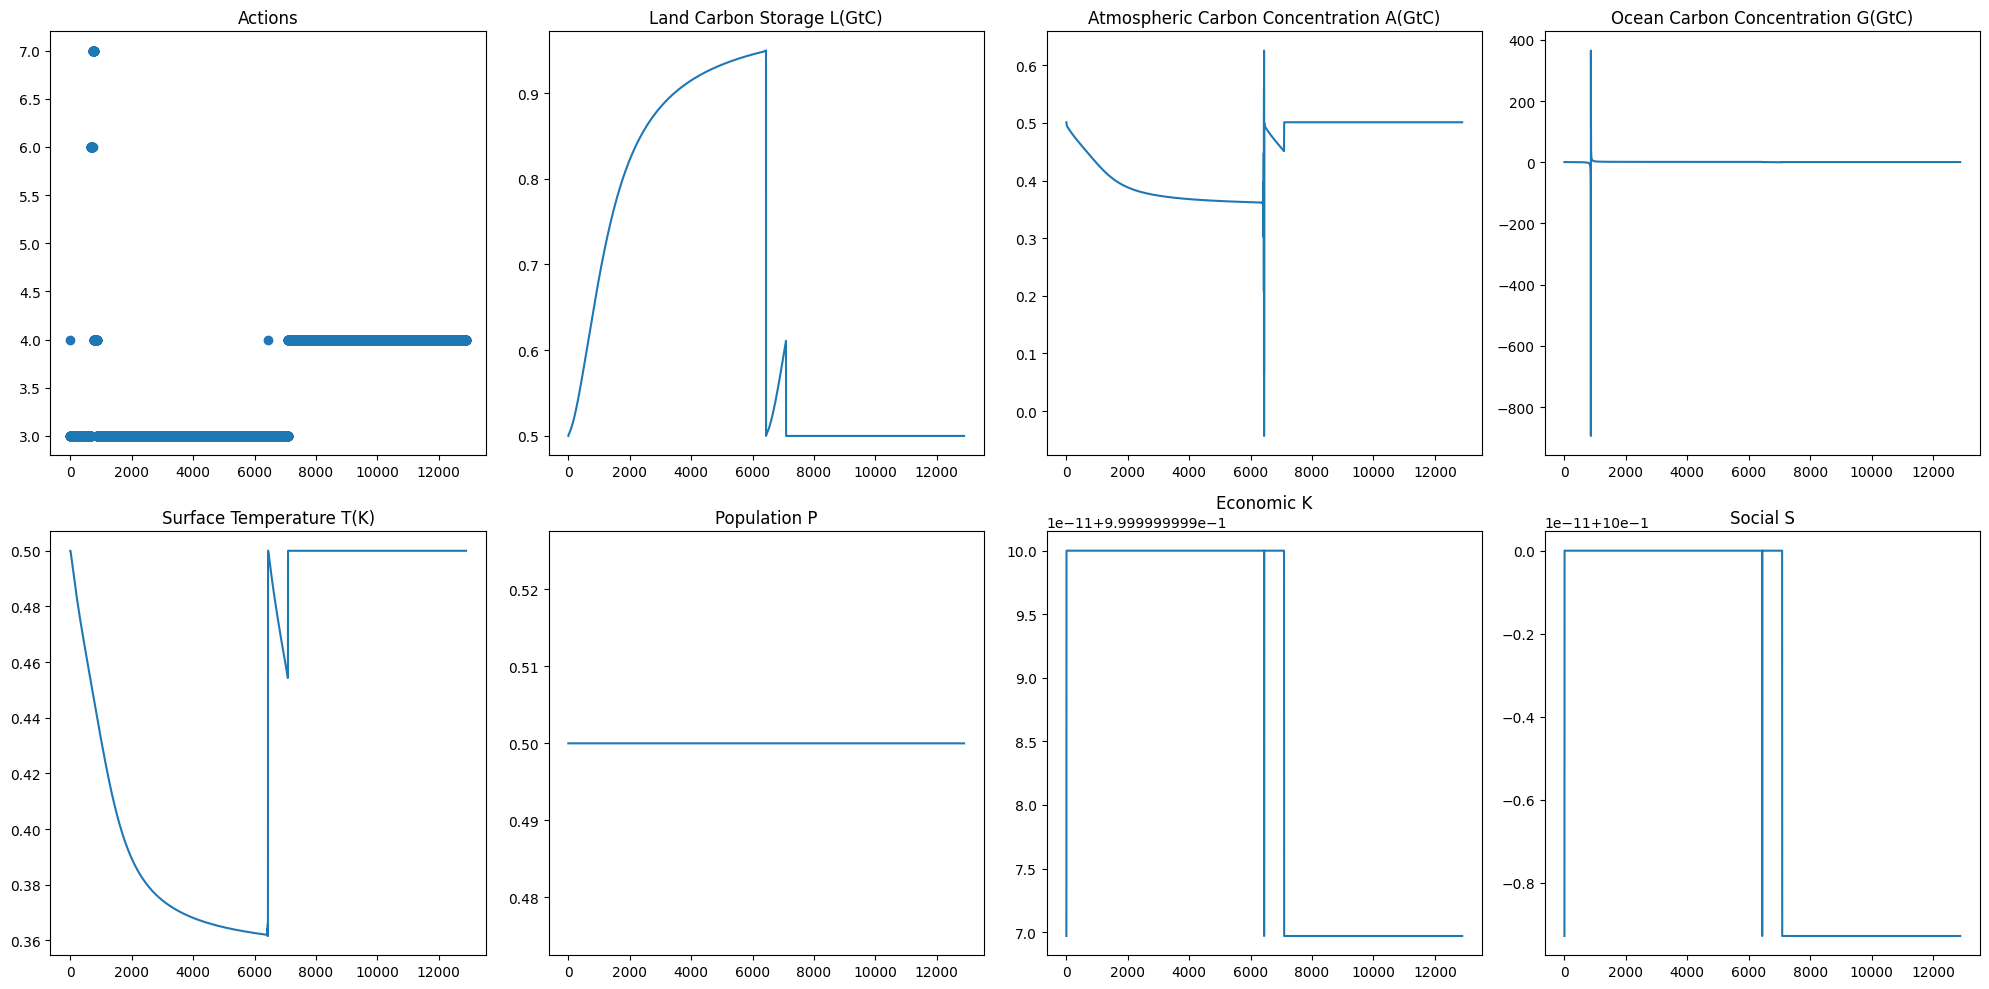

In [29]:

# 重新创建已有的环境
env = cG_LAGTPKS_Environment()

# 装载我们训练好的模型
model = A2C.load("A2C_COPAN", env=env)

# 开始运行评估操作
for i in range(1000):
    obs, info = env.reset()
    done = False
    score = 0
    # while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    
    print(obs, reward, action)
    action_number = action2number(action)
    total_action.append(action_number[0])
    total_state.append(obs)
    
    score += reward
    print(f"Episode {i+1} Score: {score}")
    
    

# 绘制状态值和动作
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# 绘制 actions
# 在 [0,0] 散点图中绘制 actions，要求使用散点图
axs[0, 0].scatter(range(len(total_action)), total_action)
axs[0, 0].set_title('Actions')

# 绘制状态值

states = total_state
states = np.array(states)

# 绘制各个状态变量随时间步变化的曲线
axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
axs[0, 1].set_title('Land Carbon Storage L(GtC)')

axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
axs[1, 0].set_title('Surface Temperature T(K)')

axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
axs[1, 1].set_title('Population P')

axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
axs[1, 2].set_title('Economic K')

axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
axs[1, 3].set_title('Social S')

plt.tight_layout()
plt.show()


